# SMART - the tutorial (Take 1)

Spatial Modeling Algorithms for Reactions and Transport (SMART) provides a convenient framework to simulate reaction networks, particularly within biological cells.
These networks are generally **mixed dimensional** and **spatial**, requiring the solution of systems of **partial differential equations**.

## Part 1: A minimal example

For illustration, we start with a minimal case of diffusion within a domain with a constant uniform degradation rate. No mixed dimensionality needed, just consider a single species, $A$ that obeys the following equation:

$$
\frac{\partial A}{\partial t} = D_A \nabla^2 A - k_{decay} A \quad \text{in} ~ \Omega_{surf} \\
D_A \nabla A \cdot \mathbf{n} = 0 \quad \text{on} ~ \Gamma_{edge}
$$

Any use of SMART will start with importing at least the `smart` and `dolfin` modules. Maybe also `matplotlib` if we want to do some plotting. It's often convenient to load in specific submodules of SMART rather than needing to refer to them by their full names during every use. For instance, instead of typing `smart.units.unit`, we might just want to use `unit`, in which case we can use the following import: `from smart.units import unit`. Overall, I recommend the following imports as a starting point for most cases.

In [ ]:
from smart import config, mesh, model, mesh_tools, visualization
from smart.units import unit
from smart.model_assembly import (
    Compartment,
    Parameter,
    Reaction,
    Species,
    SpeciesContainer,
    ParameterContainer,
    CompartmentContainer,
    ReactionContainer,
)
import logging
logger = logging.getLogger("smart")
import dolfin as d
from matplotlib import pyplot as plt

SMART also requires the user to specify units, utilizing the `pint` Python module. Mostly any units you want will be in `smart.units.unit`:

In [ ]:
D_unit = unit.um**2 / unit.s
conc_unit = unit.molecule / unit.um**2
surf_var = Compartment("surf", 2, unit.um, 1)

Following these preliminary steps, we begin the basic workflow of SMART:
1. **Initialize SMART containers**: Each container (species, compartments, reactions, or parameters) is initialized by first creating individual objects of the class `Species`, `Compartment`, `Reaction`, `Parameter`. The initialization of these objects is described in some detail in Examples [1](https://rangamanilabucsd.github.io/smart/examples/example1/example1.html) and [3](https://rangamanilabucsd.github.io/smart/examples/example3/example3.html), or more comprehensively in the [API documentation](https://rangamanilabucsd.github.io/smart/autoapi/smart/model_assembly/index.html#module-model_assembly).

    These SMART containers contain all instances of any given class. In general, the user should define an empty container of the correct type and then add all instances of each object manually. In this simple example, we consider a model with a single species (`A`) over a single surface (`surf`), with a single reaction (`r1`, with parameter `k` defining the rate of decay) corresponding to exponential decay over time. Note that the `Reaction` constructor takes in an equation written as a string, whose input arguments, `k` and `A`, are mapped to either a `Species` or `Parameter`. The input argument in the `param_map` maps from the equation variable name (`"k"`) to the name of the parameter (`"kdecay"`). Similarly, the input argument in the `species_map` maps from the equation variable name (`"sp"`) to the name of the species (`"A"`).

In [ ]:
surf_var = Compartment("surf", 2, unit.um, 1)
A_var = Species("A", "10*exp(-(x-0.5)**2-(y-0.5)**2)", conc_unit, 0.01, D_unit, "surf")
# A_var = Species("A", 1.0, conc_unit, 0.01, D_unit, "surf")
kdecay_var = Parameter("kdecay", 1, 1/unit.s)
r1_var = Reaction("r1", ["A"], [], param_map={"k":"kdecay"},
                                        species_map={"sp":"A"}, eqn_f_str="k*sp")
cc = CompartmentContainer()
cc.add([surf_var])
sc = SpeciesContainer()
sc.add([A_var])
pc = ParameterContainer()
pc.add([kdecay_var])
rc = ReactionContainer()
rc.add([r1_var])

2. **Generate/load in mesh**: Separately from defining the SMART containers, the user must either generate or load in a mesh. In Examples 2, 3, 4, and 6, this mesh is generated using [Gmsh](https://gmsh.info/), via our module `mesh_tools`. Then [meshio](https://github.com/nschloe/meshio) is used to convert the `.msh` file generated by [Gmsh](https://gmsh.info/) into a mesh for use by DOLFIN (the computational backend of [FEniCS](https://fenicsproject.org/)). Alternatively, Examples 1 and 5 use built-in mesh functions in DOLFIN (either `d.RectangleMesh()` or `d.UnitCubeMesh()`). For some applications, the user may wish to generate a mesh using other software. These can then be loaded in for use by SMART by using [meshio](https://github.com/nschloe/meshio) to convert to an [XDMF-file](https://www.xdmf.org/index.php/XDMF_Model_and_Format) and loading into dolfin using `d.XDMFFile()`. (see `mesh_tools.gmsh_to_dolfin` for an example).

    Note that the user should also provide two mesh marker functions defined over the facets and cells of the mesh (for a 3D model, the facet mesh function includes all 2D "surface" elements and the cell mesh function includes all 3D "volume" elements). Each of these objects should be of the class `d.MeshFunction`, type `size_t`. The values of these functions over the mesh indicate the compartments to which each region belongs. For the demos that use [Gmsh](https://gmsh.info/), these marker functions are defined by adding physical groups to the mesh and then converting to `d.MeshFunction`'s in `mesh_tools.gmsh_to_dolfin`. In Examples 1 and 5, mesh functions are defined after generating the dolfin mesh. For other examples of defining mesh functions in DOLFIN, see FEniCS tutorials; for instance, https://fenicsproject.org/olddocs/dolfin/latest/python/demos/subdomains-poisson/documentation.html.

    Once the DOLFIN mesh and mesh functions have been defined, they should be written to file using the function `mesh_tools.write_mesh`. This generates an hdf5 file that is readable by SMART. Finally, the `mesh.ParentMesh` object is defined. In our simple example here, we generate a dolfin mesh using `d.RectangleMesh`:

In [ ]:
rect_mesh = d.RectangleMesh(d.Point(0.0, 0.0), d.Point(1.0, 1.0), 10, 10)
mf2 = d.MeshFunction("size_t", rect_mesh, 2, 1)
mf1 = d.MeshFunction("size_t", rect_mesh, 1, 0)
mesh_tools.write_mesh(rect_mesh, mf1, mf2, "rect_mesh.h5")
parent_mesh = mesh.ParentMesh(mesh_filename="rect_mesh.h5", mesh_filetype="hdf5", name="parent_mesh")

3. **Initialize model object**: Once the SMART containers and the parent mesh have been defined, these can all be used to assemble a single `model` object. In our example, we initialize the model object with the default configuration:

In [ ]:
config_cur = config.Config()
model_cur = model.Model(pc, sc, cc, rc, config_cur, parent_mesh)

4. **Specify solver configuration**: SMART solves the assembled reaction-transport equations using the finite element method. This finite element system is assembled using [FEniCS](https://fenicsproject.org/) and is then solved using [SNES in PETSc4Py](https://petsc.org/release/manual/snes/#ch-snes). The user can provide problem-tailored solver specifications by calling `config_cur.solver.update()` (given a config object, `config_cur`). Minimally, the user should provide a time step and final time for the simulation:

In [ ]:
config_cur.solver.update({"final_t": 1.0, "initial_dt": 0.1})

In this manner, the user can also specify "time_precision" (number of digits past the decimal point to round time, default is 6) and "print_assembly" (prints information during assembly process, default is True).

5. **Initialize variational problem and solver**: Once the model object has been initialized and the config object has been set, we can initialize the variational problem in FEniCS and initialize the SNES solver in PETSc. This is all done internally by calling the single function:

In [ ]:
model_cur.initialize()

 Advanced users may wish to alter the default SNES preconditioners and solvers used in SMART. An example of how to do so is included in Example 6; generally, this involves calling functions within the `model.Model.solver` object. For instance, to change the solver tolerance, we can write `model_cur.solver.setTolerances(rtol=1e-4)`. See the [SNES API](https://www.mcs.anl.gov/petsc/petsc4py-current/docs/apiref/petsc4py.PETSc.SNES-class.html) for more information about the SNES class.
 
6. **Start simulation**: Initially, data is saved to an [XDMF-file](https://www.xdmf.org/index.php/XDMF_Model_and_Format) before entering a loop to solve the system until the current time is greater than the specified final time. At each time step, the resulting distribution of `A` is stored to file, and the average of each species (in this case just `A`) is stored to a list that can be accessed after the loop. The solution at each time step can be accessed through the species container using an expression of the form `sc["species_name"].sol`. Note that here we change the logging level to WARNING to mitigate some of the overflow of output.

In [ ]:
results = d.XDMFFile(model_cur.mpi_comm_world, "A.xdmf")
results.parameters["flush_output"] = True
results.write(model_cur.sc["A"].sol, model_cur.t)
dx = d.Measure("dx", domain=model_cur.cc["surf"].dolfin_mesh)
int_val = d.assemble(model_cur.sc["A"].sol*dx)
volume = d.assemble(1.0*dx)
avg_A = [int_val / volume]
logger.setLevel(logging.WARNING)
while True:
    model_cur.monolithic_solve()
    print(f"Done with t = {model_cur.t}")
    results.write(model_cur.sc["A"].sol, model_cur.t)
    int_val = d.assemble(model_cur.sc["A"].sol*dx)
    avg_A.append(int_val / volume)
    if model_cur.t >= model_cur.final_t:
        break

7. **End simulation and visualize data**: We recommend writing data to XDMF-files as shown in the previous step. These can then be readily visualized and post-processed in [Paraview](https://www.paraview.org/). Alternatively, the mesh and results can be viewed in Python using Pyvista; the `smart.visualization` module offers Pyvista-based options for visualization and is used throughout the SMART demos.

In [ ]:
visualization.plot(model_cur.sc['A'].u['u'])

Finally, we also note that certain data analysis tasks, such as tracking the average concentration over time by integrating at each time step, can be easily done using built-in DOLFIN function in the Python script. For instance, in the above script, we used `d.assemble` to integrate A over the surface when computing the average at each time point. In an interactive setting, we can visualize these results using matplotlib; for example:

In [ ]:
plt.plot(model_cur.tvec, avg_A)
plt.xlabel('Time (s)')
plt.ylabel('A concentration $\mathrm{(molecules/μm^2)}$')
plt.show()

## Part 2: What about this mixed dimensionality business?

The example we built so far just involves diffusion and reaction of a species over a single domain. We might wish to consider a case in which species $A$ is produced (or degraded) at one edge of the domain. In this case, we could modify the equations like this:

$$
\frac{\partial A}{\partial t} = D_A \nabla^2 A - k_{decay} A \quad \text{in} ~ \Omega_{surf} \\
D_A \nabla A \cdot \mathbf{n} = J_A \quad \text{on} ~ \Gamma_{edge,top} \\
D_A \nabla A \cdot \mathbf{n} = 0 \quad \text{on} ~ \Gamma_{edge,other}
$$

Previously, we did not define any boundary domain, in which case SMART defaults to assuming no flux over an open boundaries. Here, we can mark the edge of our geometry using `mf1`. A convenient way to change boundary markers is as follows:

In [ ]:
# Create classes for defining parts of the boundary
class Top(d.SubDomain):
    def inside(self, x, on_boundary):
        return d.near(x[1], 1.0) and on_boundary
# Initialize sub-domain instances
top_marker = Top()
mf1 = d.MeshFunction("size_t", rect_mesh, 1, 0)
top_marker.mark(mf1, 10)
top_var = Compartment("top", 1, unit.um, 10)

We now add an associated reaction occuring at the "top" surface and add the new compartment, reaction, and parameter to our SMART containers.

In [ ]:
flux_unit = unit.molecule / (unit.um * unit.s)
J_A_var = Parameter("J_A", 1.0, flux_unit)
r2_var = Reaction("r2", [], ["A"], param_map={"J":"J_A"}, 
                                       eqn_f_str="J", explicit_restriction_to_domain="top")
cc.add([top_var])
pc.add([J_A_var])
rc.add([r2_var])

And we can run the simulation again for these conditions.

In [ ]:
mesh_tools.write_mesh(rect_mesh, mf1, mf2, "rect_mesh.h5")
parent_mesh = mesh.ParentMesh(mesh_filename="rect_mesh.h5", mesh_filetype="hdf5", name="parent_mesh")
config_cur = config.Config()
model_cur = model.Model(pc, sc, cc, rc, config_cur, parent_mesh)
config_cur.solver.update({"final_t": 1.0, "initial_dt": 0.1})
model_cur.initialize()
results = d.XDMFFile(model_cur.mpi_comm_world, "A.xdmf")
results.parameters["flush_output"] = True
results.write(model_cur.sc["A"].sol, model_cur.t)
dx = d.Measure("dx", domain=model_cur.cc["surf"].dolfin_mesh)
volume = d.assemble(1.0*dx)
int_val = d.assemble(model_cur.sc["A"].sol*dx)
avg_A = [int_val/volume]
while True:
    model_cur.monolithic_solve()
    print(f"Done with t = {model_cur.t}")
    results.write(model_cur.sc["A"].sol, model_cur.t)
    int_val = d.assemble(model_cur.sc["A"].sol*dx)
    avg_A.append(int_val / volume)
    if model_cur.t >= model_cur.final_t:
        break
visualization.plot(model_cur.sc['A'].u['u'])
plt.plot(model_cur.tvec, avg_A)
plt.xlabel('Time (s)')
plt.ylabel('A concentration $\mathrm{(molecules/μm^2)}$')
plt.show()

Even better, we might consider the case in which $A$ can bind and unbind from the top surface. Then we have a **mixed dimensional system of PDEs**. For clarity, we differentiate $A$ in the bulk vs the boundary by writing $A_{bound}$ for its bound state:

$$
\frac{\partial A}{\partial t} = D_{A} \nabla^2 A - k_{decay} A \quad \text{in} ~ \Omega_{surf} \\
D_{A} \nabla A \cdot \mathbf{n} = k_{off} A_{bound} - k_{on} A \quad \text{on} ~ \Gamma_{top} \\
D_{A} \nabla A \cdot \mathbf{n} = 0 \quad \text{on} ~ \Gamma_{edge,other} \\
\\
\frac{\partial A_{bound}}{\partial t} = D_{A,bound} \nabla^2 A_{bound} + k_{on} A - k_{off} A_{bound}  \quad \text{on} ~ \Gamma_{top}
$$

Crucially, what is a boundary condition for $A_{bulk}$ becomes a reaction term in the PDE for $A_{bound}$!
Note that we do have an open boundary of the boundary domain (the surface is not closed). In this case, SMART assumes no flux at the edge points.

We can introduce our new species and reaction, overwriting the previous `r2`:

In [ ]:
edge_unit = unit.molecule / unit.um
A_bound_var = Species("A_bound", 0.0, edge_unit, 0.01, D_unit, "top")
kon_var = Parameter("kon", 1.0, unit.um/unit.s)
koff_var = Parameter("koff", 1.0, 1/unit.s)
r2_var = Reaction("r2", ["A"], ["A_bound"], param_map={"on":"kon", "off": "koff"}, 
                                       eqn_f_str="A*kon - A_bound*koff", explicit_restriction_to_domain="top")
sc.add([A_bound_var])
pc.remove("J_A")
pc.add([kon_var, koff_var])
rc.add([r2_var])

Now we rerun the simulation.

In [ ]:
parent_mesh = mesh.ParentMesh(mesh_filename="rect_mesh.h5", mesh_filetype="hdf5", name="parent_mesh")
config_cur = config.Config()
model_cur = model.Model(pc, sc, cc, rc, config_cur, parent_mesh)
config_cur.solver.update({"final_t": 1.0, "initial_dt": 0.1})
model_cur.initialize()
results = dict()
for species_name, species in model_cur.sc.items:
    results[species_name] = d.XDMFFile(model_cur.mpi_comm_world, f"{species_name}.xdmf")
    results[species_name].parameters["flush_output"] = True
    results[species_name].write(model_cur.sc[species_name].sol, model_cur.t)
dx = d.Measure("dx", domain=model_cur.cc["surf"].dolfin_mesh)
volume = d.assemble(1.0*dx)
int_val = d.assemble(model_cur.sc["A"].sol*dx)
avg_A = [int_val/volume]
while True:
    model_cur.monolithic_solve()
    print(f"Done with t = {model_cur.t}")
    for species_name, species in model_cur.sc.items:
        results[species_name].write(model_cur.sc[species_name].sol, model_cur.t)
    int_val = d.assemble(model_cur.sc["A"].sol*dx)
    avg_A.append(int_val / volume)
    if model_cur.t >= model_cur.final_t:
        break
visualization.plot(model_cur.sc['A'].u['u'])
plt.plot(model_cur.tvec, avg_A)
plt.xlabel('Time (s)')
plt.ylabel('A concentration $\mathrm{(molecules/μm^2)}$')
plt.show()

## Part 3: Cells aren't squares

We talk a lot about how cells are not spherical cows (and they certainly are not two dimensional). So we can consider a slightly more nuanced case of an ellipsoid, which can easily be meshed using existing functions in SMART. Note that all units need to be adjusted to the 3D case here, but we can still utilize the same model. I recommend restarting the kernel to clear the previous version of the model, then reimporting the modules here.

In [ ]:
from smart import config, mesh, model, mesh_tools, visualization
from smart.units import unit
from smart.model_assembly import (
    Compartment,
    Parameter,
    Reaction,
    Species,
    SpeciesContainer,
    ParameterContainer,
    CompartmentContainer,
    ReactionContainer,
)
import logging
logger = logging.getLogger("smart")
import dolfin as d
from matplotlib import pyplot as plt

dmesh, mf2, mf3 = mesh_tools.create_ellipsoids([1,1.5,4], [0,0,0], hEdge=0.2)
mesh_tools.write_mesh(dmesh, mf2, mf3, "ellipsoid.h5")

Now we run this example, either with the ellipsoid we just created ("ellipsoid.h5"), or using another 3D mesh stored in this repository. "spine_mesh.h5" can be used for a realistic dendritic spine featured in many of our previous papers (e.g., see [the GAMer2 paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007756) or [the SMART paper](https://www.nature.com/articles/s43588-024-00745-x)), or "spot_mesh.h5" can be used for a non-spherical cow (courtesy of [Keenan Crane](https://www.cs.cmu.edu/~kmcrane/Projects/ModelRepository/))

In [ ]:
mesh_file = "ellipsoid.h5"
D_unit = unit.um**2 / unit.s
conc_unit = unit.molecule / unit.um**3
surf_unit = unit.molecule / unit.um**2
cyto_var = Compartment("cyto", 3, unit.um, 1)
pm_var = Compartment("pm", 2, unit.um, 10)
A_var = Species("A", 10, conc_unit, 0.1, D_unit, "cyto")
kdecay_var = Parameter("kdecay", 0, 1/unit.s)
r1_var = Reaction("r1", ["A"], [], param_map={"k":"kdecay"},
                                        species_map={"sp":"A"}, eqn_f_str="k*sp")
A_bound_var = Species("A_bound", 0.0, surf_unit, 0.01, D_unit, "pm")
kon_var = Parameter("kon", 1.0, unit.um/unit.s)
koff_var = Parameter("koff", 1.0, 1/unit.s)
r2_var = Reaction("r2", ["A"], ["A_bound"], param_map={"on":"kon", "off": "koff"}, 
                                       eqn_f_str="A*kon - A_bound*koff", explicit_restriction_to_domain="pm")
cc = CompartmentContainer()
cc.add([cyto_var, pm_var])
sc = SpeciesContainer()
sc.add([A_var, A_bound_var])
pc = ParameterContainer()
pc.add([kdecay_var, kon_var, koff_var])
rc = ReactionContainer()
rc.add([r1_var, r2_var])
parent_mesh = mesh.ParentMesh(mesh_filename=mesh_file, mesh_filetype="hdf5", name="parent_mesh")
config_cur = config.Config()
model_cur = model.Model(pc, sc, cc, rc, config_cur, parent_mesh)
config_cur.solver.update({"final_t": 1.0, "initial_dt": 0.05})
model_cur.initialize()
results = dict()
for species_name, species in model_cur.sc.items:
    results[species_name] = d.XDMFFile(model_cur.mpi_comm_world, f"{species_name}.xdmf")
    results[species_name].parameters["flush_output"] = True
    results[species_name].write(model_cur.sc[species_name].sol, model_cur.t)
avg_A = [A_var.initial_condition]
dx = d.Measure("dx", domain=model_cur.cc["cyto"].dolfin_mesh)
volume = d.assemble(1.0*dx)
logger.setLevel(logging.WARNING) # suppress excessive output
while True:
    model_cur.monolithic_solve()
    print(f"Done with t = {model_cur.t}")
    for species_name, species in model_cur.sc.items:
        results[species_name].write(model_cur.sc[species_name].sol, model_cur.t)
    int_val = d.assemble(model_cur.sc["A"].sol*dx)
    avg_A.append(int_val / volume)
    if model_cur.t >= model_cur.final_t:
        break
plt.plot(model_cur.tvec, avg_A)
plt.xlabel('Time (s)')
plt.ylabel('A concentration $\mathrm{(molecules/μm^2)}$')
plt.show()

## Part 4: A few special features

SMART has some additional features worth highlighting here:
* Adaptive time-stepping
* Parameters that vary over space and time
* Curvature-dependent initial conditions and reactions
* Axisymmetric assumption

Below, we demonstrate use of a spatially varying parameter and curvature-dependent reactions. Curvature-dependent conditions are also shown in `example2_withcurv.ipynb` in the `smart` repository. Temporally varying parameters and adaptive time-stepping are included in `example6.ipynb` and the axisymmetric feature is included in `example3_withaxisymm`.

Here, we first read in a mesh and compute the curvature.

In [ ]:
mesh_file = 'spine_mesh.h5'#"spot_mesh.h5" # again, test any of the .h5 mesh files here
dmesh = d.Mesh()
hdf5 = d.HDF5File(dmesh.mpi_comm(), mesh_file, "r")
hdf5.read(dmesh, "/mesh", False)
mf2 = d.MeshFunction("size_t", dmesh, 2)
hdf5.read(mf2, f"/mf2")
mf3 = d.MeshFunction("size_t", dmesh, 3)
hdf5.read(mf3, f"/mf3")
hdf5.close()
mf_curv = mesh_tools.compute_curvature(dmesh, mf2, mf3, [10], [1])

parent_mesh = mesh.ParentMesh(mesh_filename=mesh_file,
                                    mesh_filetype="hdf5", name="parent_mesh",
                                    curvature=mf_curv,
)

Now rerun the simulation with a curvature-sensitive reaction rate in `r2` (`curv_sens = True`) and/or a spatially dependent `kon` (`spatial_param = True`).

╒════╤═════════════╤══════╤══════════════════╤═════════════╤══════════════╤════════════════╕
│    │ name        │   id │   dimensionality │   num_cells │   num_facets │   num_vertices │
╞════╪═════════════╪══════╪══════════════════╪═════════════╪══════════════╪════════════════╡
│  0 │ parent_mesh │ 1936 │                3 │       48096 │       103186 │          11562 │
├────┼─────────────┼──────┼──────────────────┼─────────────┼──────────────┼────────────────┤
│  1 │ cyto        │ 2888 │                3 │       48096 │       103186 │          11562 │
├────┼─────────────┼──────┼──────────────────┼─────────────┼──────────────┼────────────────┤
│  2 │ pm          │ 2895 │                2 │       13107 │        19727 │           6620 │
╘════╧═════════════╧══════╧══════════════════╧═════════════╧══════════════╧════════════════╛
Done with t = 0.050000
Done with t = 0.100000
Done with t = 0.150000
Done with t = 0.200000
Done with t = 0.250000
Done with t = 0.300000
Done with t = 0.350000
Do

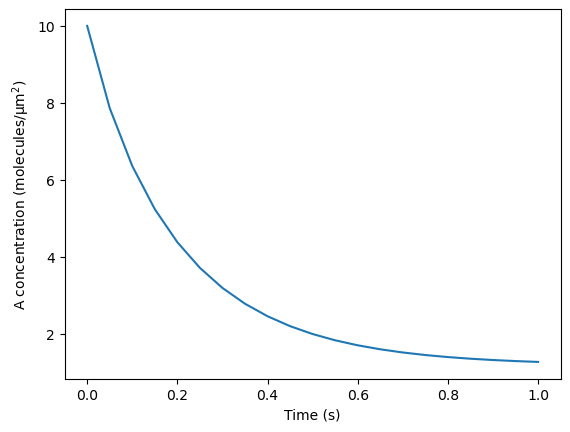

In [6]:
curv_sens = True
spatial_param = False

D_unit = unit.um**2 / unit.s
conc_unit = unit.molecule / unit.um**3
surf_unit = unit.molecule / unit.um**2
cyto_var = Compartment("cyto", 3, unit.um, 1)
pm_var = Compartment("pm", 2, unit.um, 10)
A_var = Species("A", 10, conc_unit, 0.1, D_unit, "cyto")
kdecay_var = Parameter("kdecay", 0, 1/unit.s)
r1_var = Reaction("r1", ["A"], [], param_map={"k":"kdecay"},
                                        species_map={"sp":"A"}, eqn_f_str="k*sp")
A_bound_var = Species("A_bound", 0.0, surf_unit, 0.01, D_unit, "pm")
if spatial_param:
    kon_var = Parameter.from_expression("kon", "exp(-5*x)", unit.um/unit.s)
else:
    kon_var = Parameter("kon", 1.0, unit.um/unit.s)
koff_var = Parameter("koff", 1.0, 1/unit.s)
cc = CompartmentContainer()
sc = SpeciesContainer()
pc = ParameterContainer()
rc = ReactionContainer()
if curv_sens:
    curv0_var = Parameter("curv0", max(mf_curv.array())/2, 1/unit.um)
    r2_var = Reaction("r2", ["A"], ["A_bound"], param_map={"on":"kon", "off": "koff", "curv0": "curv0"}, 
                                        eqn_f_str="A*kon*exp(-curv/curv0) - A_bound*koff", explicit_restriction_to_domain="pm")
    pc.add([curv0_var])
else:
    r2_var = Reaction("r2", ["A"], ["A_bound"], param_map={"on":"kon", "off": "koff"}, 
                                       eqn_f_str="A*kon - A_bound*koff", explicit_restriction_to_domain="pm")
cc.add([cyto_var, pm_var])
sc.add([A_var, A_bound_var])
pc.add([kdecay_var, kon_var, koff_var])
rc.add([r1_var, r2_var])

config_cur = config.Config()
model_cur = model.Model(pc, sc, cc, rc, config_cur, parent_mesh)
config_cur.solver.update({"final_t": 1.0, "initial_dt": 0.05})
model_cur.initialize()
results = dict()
for species_name, species in model_cur.sc.items:
    results[species_name] = d.XDMFFile(model_cur.mpi_comm_world, f"{species_name}.xdmf")
    results[species_name].parameters["flush_output"] = True
    results[species_name].write(model_cur.sc[species_name].sol, model_cur.t)
# save curvature for easy reference
d.File("curv.pvd") << model_cur.mf0_to_fun(mf_curv, A_bound_var.V)
avg_A = [A_var.initial_condition]
dx = d.Measure("dx", domain=model_cur.cc["cyto"].dolfin_mesh)
volume = d.assemble(1.0*dx)
while True:
    model_cur.monolithic_solve()
    print(f"Done with t = {model_cur.t}")
    for species_name, species in model_cur.sc.items:
        results[species_name].write(model_cur.sc[species_name].sol, model_cur.t)
    int_val = d.assemble(model_cur.sc["A"].sol*dx)
    avg_A.append(int_val / volume)
    if model_cur.t >= model_cur.final_t:
        break
plt.plot(model_cur.tvec, avg_A)
plt.xlabel('Time (s)')
plt.ylabel('A concentration $\mathrm{(molecules/μm^2)}$')
plt.show()